# Fused lasso法で累帯構造の不連続変化点を検出する

1. データセット読み込み
1. 解析粒子を切り出し
1. fused lasso 

Fused lasso: データ数とパラメータ数が等しい. 隣り合うパラメータの差が小さくなるようにフィッティングを行う. 

$$
    argmin\left[ \sum^N_{i=1}\left(y_i - \beta_i \right)^2 + \lambda \sum^{N-1}_{i=1}\left( \left|\beta_{j+1} - \beta_j\right| \right) \right]
$$

このような正則化項の場合, 回帰の目的関数はステップ関数を想定することになる.

1次関数が連結したような折れ線グラフへの回帰を行うには, 例えば正則化項を

$$
    \lambda\sum\left|\frac{1}{2} \left(\beta_{j+1} + \beta_{j-1}\right) - \beta_j \right|
$$

とすればよい

### 参考

- [genlasso document](../../../ドキュメント/Articles/Machine_learning/genlasso_documents.pdf)

In [15]:
library(genlasso)
library(dplyr)
library(tidyr)
library(broom)
library(purrr)

# 所与のデータ(ys)に関数(func)を適用しつつ, データysそのものを返す関数
tee <- function(ys,func){
    func(ys)
    return (ys)
}

getColumn <- function(df,columnName){
    return(df[columnName])
}

## Demo

In [13]:
print(sample(1:10,10,replace=TRUE)) 
print(rep(2,each=n/10))


 [1] 7 6 5 3 7 3 3 9 6 5
 [1] 2 2 2 2 2 2 2 2 2 2


Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
[1] 0.1266858


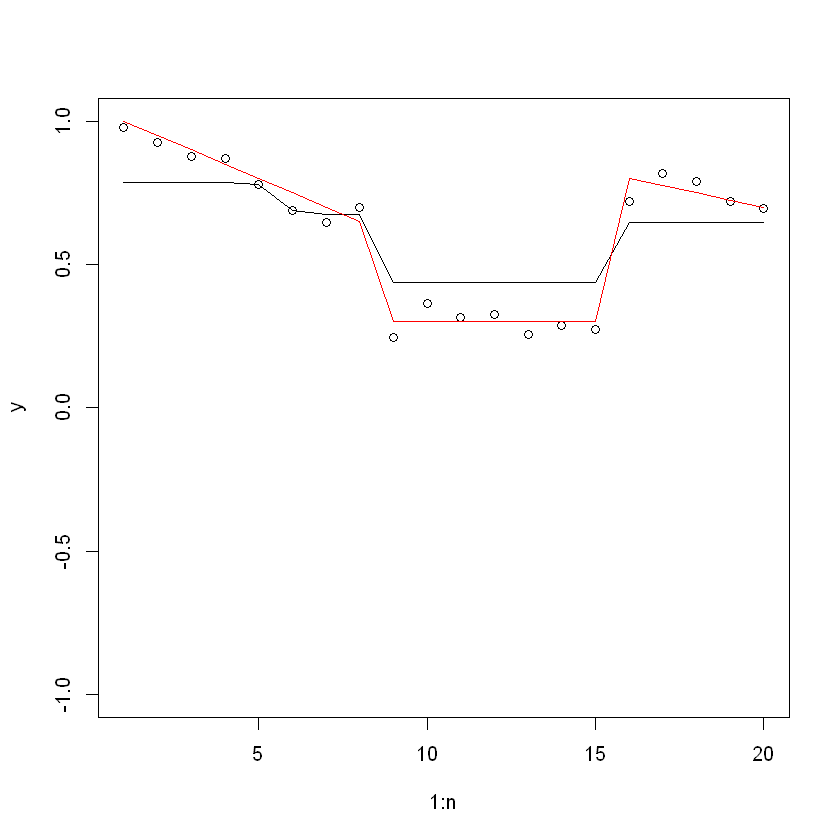

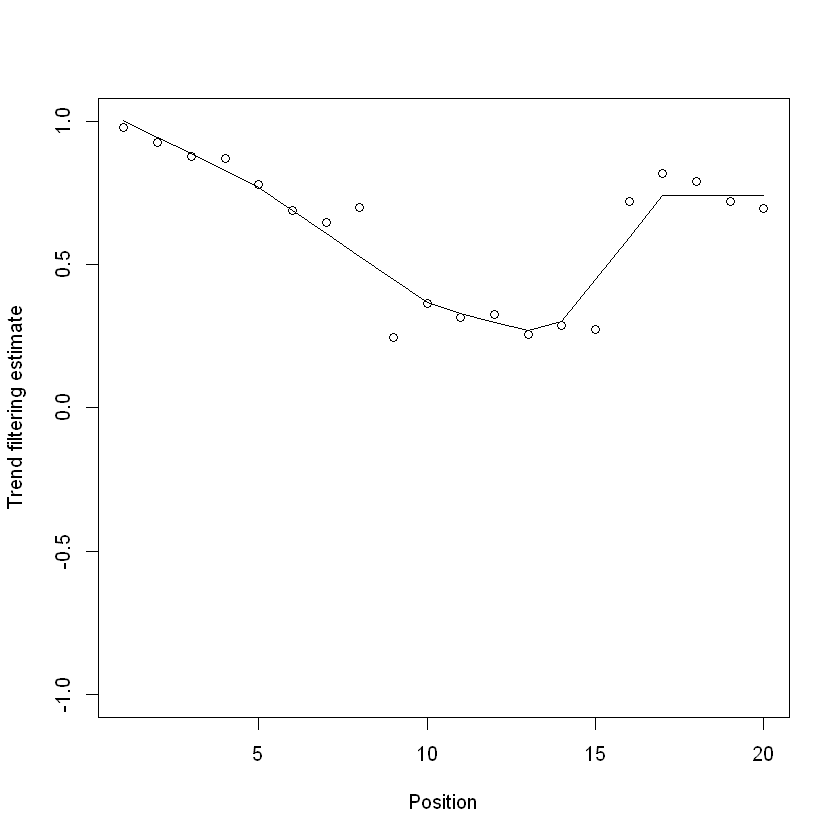

In [7]:
set.seed(71)
n <- 20
beta.true <- c(1,0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.8,0.775,0.75,0.725,0.7)
lambda <- 0.5 # λを小さくすると, スパース性が小さくなり, 元のデータに忠実になっていく
y <- beta.true + rnorm(n,sd=0.05)

y %>% 
    fusedlasso1d %>%
    coef(lambda=lambda) %>%
    tee(function(coef){
        plot(1:n, y, ylim = c(-1,1))
        lines(1:n, coef$beta)
        lines(1:n, beta.true,col="red")
    }) %>%
    invisible
 

y %>%
    trendfilter(ord=1) %>%
    cv.trendfilter %>%
    tee(function(cv){
        print(cv$lambda.1se)
        y %>%
            trendfilter(ord=1) %>%
            plot(, lambda=cv$lambda.1se,ylim = c(-1,1)) %>%
            invisible
    }) %>%
    invisible

# 斑晶の組成プロファイルに対するfused lassoの適用

To detencting abrupt change of chemical profile, 
Applying fused lasso method to chemical profile of Cr in orthopyroxene phenocryst in HMA lava in the SVB.

Fused lassoをそのまま使うことは, ステップ関数の復元には適しているが, 組成プロファイルのようにシグナルが位置や時間の関数になっている場合には適していない.

L1正則化項を隣り合うパラメータの変化率に変えることで, 

## データセット

Onedrive/My_log/htmls/data/SVB/mineral/EPMA/opx_zoning_compile.csv

- 複数の斑晶の組成プロファイルが収められている.
- それぞれのプロファイルは"comment"列の内容で区別される.
- 中心からの半径は"radius"行を参照

In [2]:
df <- read.csv("../data/SVB/mineral/EPMA/opx_zoning_compile.csv")

df$comment %>% unique

[1] 1002-9-1A-4_Line1           1002-9-1C-1_Line1          
[3] 1002-9-1D-2_Line1           2013_0815_1002-9-1C-OpxOl-1
[5] 2013_0815_1002-9-1C-OpxOl-2 1002-9-1D-2                
[7] 1002-9-1D-Opx8-1            1002-9-1D-Opx8-2           
8 Levels: 1002-9-1A-4_Line1 1002-9-1C-1_Line1 ... 2013_0815_1002-9-1C-OpxOl-2

## 1002-9-1C-1_Line1 のCrプロファイルへの適用

In [52]:
df %>%
    subset(comment == "1002-9-1C-1_Line1") %>%
    head(5) 

,ID,date,No,SiO2,Al2O3,TiO2,FeO,MnO,MgO,CaO,...,Total,Phase,pos,comment,distanse,radius,Fe.Mg,Mg.,stage,cordinate
75,304,2013_0727,43,55.289,0.940,0,12.708,0.343,28.257,1.800,...,99.566,opx,42,1002-9-1C-1_Line1,84,-196,0.2524093,79.84610,9,l
76,305,2013_0727,44,55.196,0.987,0,12.179,0.294,28.501,1.625,...,98.994,opx,43,1002-9-1C-1_Line1,86,-194,0.2398312,80.65614,9,l
77,306,2013_0727,45,55.598,1.393,0,11.089,0.265,29.291,1.595,...,99.507,opx,44,1002-9-1C-1_Line1,88,-192,0.2124772,82.47578,9,l
78,307,2013_0727,46,55.543,2.112,0,10.191,0.242,29.816,1.369,...,99.652,opx,45,1002-9-1C-1_Line1,90,-190,0.1918323,83.90443,9,l
79,308,2013_0727,47,55.088,2.486,0,8.715,0.195,30.931,1.389,...,99.218,opx,46,1002-9-1C-1_Line1,92,-188,0.1581349,86.34573,9,l


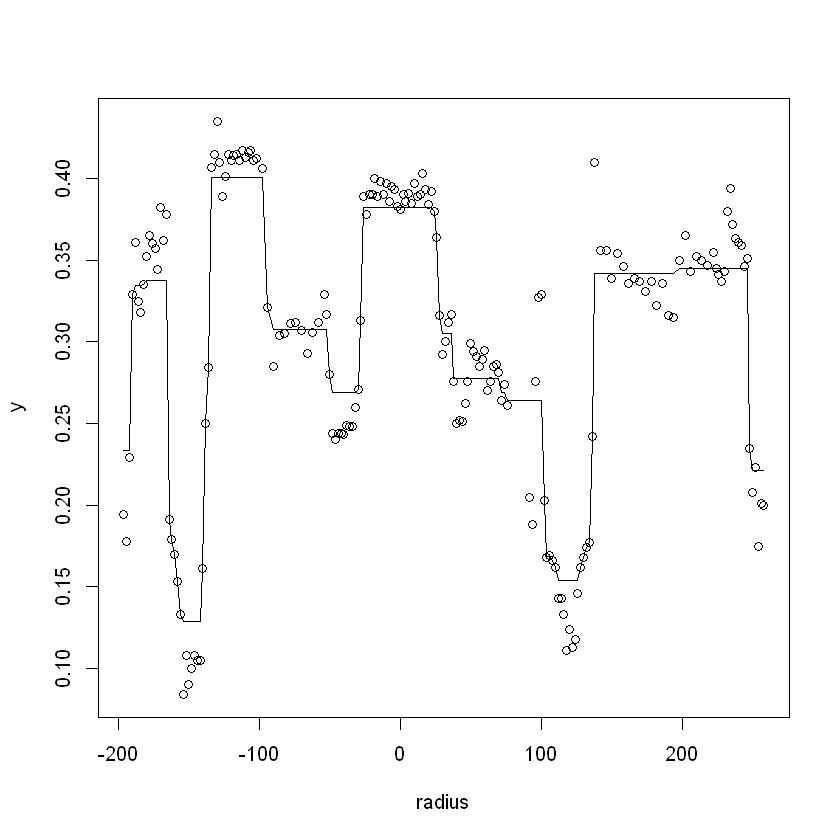

In [10]:
df %>%
    subset(comment == "1002-9-1C-1_Line1") %>%
    .$Cr2O3 -> y

df %>% 
    subset(comment == "1002-9-1C-1_Line1") %>% 
    .$radius -> radius

lambda <- 0.1

y %>%
    fusedlasso1d %>%
    coef(lambda=lambda) %>%
    tee(function(coef){
        plot(radius, y)
        lines(radius, coef$beta)
    }) %>%
    invisible
    

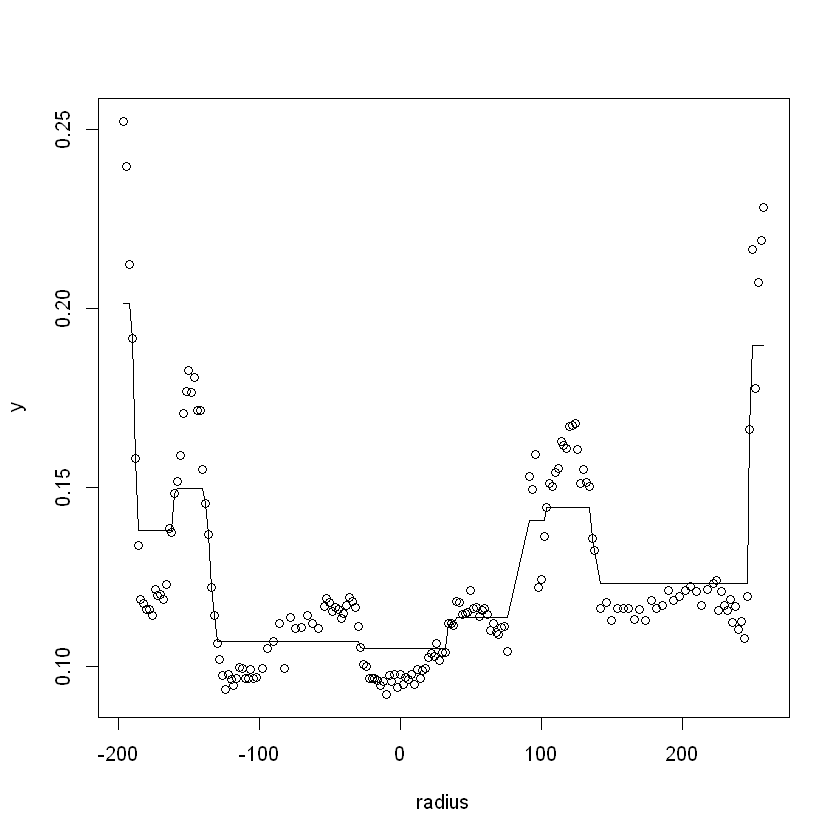

In [12]:
df %>%
    subset(comment == "1002-9-1C-1_Line1") %>%
    .$Fe.Mg -> y

df %>% 
    subset(comment == "1002-9-1C-1_Line1") %>% 
    .$radius -> radius

lambda <- 0.1

y %>%
    fusedlasso1d %>%
    coef(lambda=lambda) %>%
    tee(function(coef){
        plot(radius, y)
        lines(radius, coef$beta)
    }) %>%
    invisible

## トレンドフィルター

例えば, 複数の直線が連結したものとしてプロファイルにフィッティング

```r
trandfilter(y, ord = 1) # ord = order of polynominal function
```

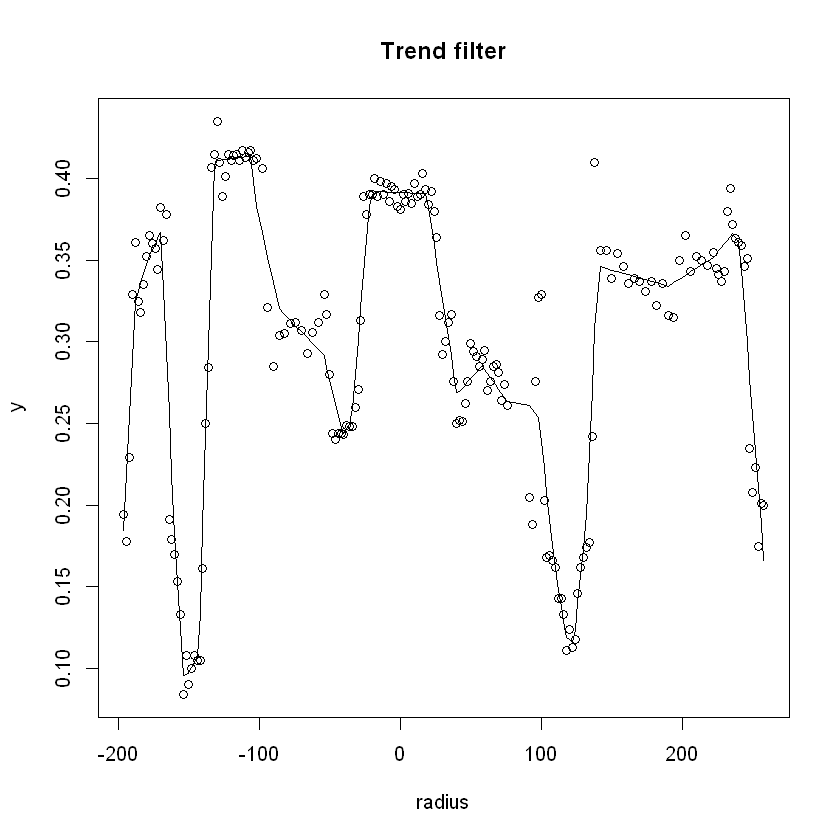

In [13]:
df %>%
    subset(comment == "1002-9-1C-1_Line1") %>%
    .$Cr2O3 -> y

df %>% 
    subset(comment == "1002-9-1C-1_Line1") %>% 
    .$radius -> radius

lambda <- 0.1

y %>%
    trendfilter(ord=1) %>%
    coef(lambda=lambda) %>%
    tee(function(coef){
        plot(radius, y, main="Trend filter")
        lines(radius, coef$beta)
    }) %>%
    invisible

### Cross validation

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
[1] 0.009998901


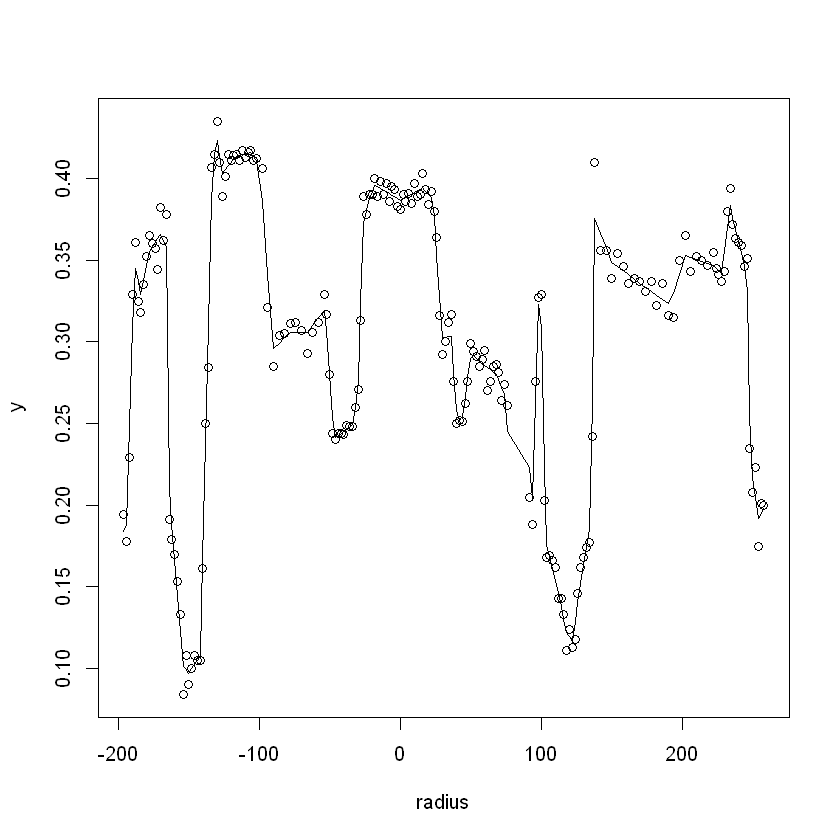

In [30]:
df %>%
    subset(comment == "1002-9-1C-1_Line1") %>%
    .$Cr2O3 -> y

df %>% 
    subset(comment == "1002-9-1C-1_Line1") %>% 
    .$radius -> radius

y %>%
    trendfilter(ord=1) %>%
    cv.trendfilter %>%
    tee(function(cv){
        print(cv$lambda.1se)
        y %>%
            trendfilter(ord=1) %>%
            coef(lambda=cv$lambda.1se) %>%
            tee(function(coef){
                plot(radius, y)
                lines(radius, coef$beta)
            }) %>% invisible
            #plot(,x=radius, lambda=cv$lambda.1se) %>%
            #invisible
    }) %>%
    invisible
